In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xbm-random/df_bax_cleaned_to_view_outliers.csv


Training data shape: (2919, 5), (2919,)
Testing data shape: (730, 5), (730,)

Starting Randomized Search for hyperparameter tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Randomized Search complete.

Best Parameters found: {'colsample_bytree': 0.9332779646944658, 'learning_rate': 0.04467293070155442, 'max_depth': 3, 'n_estimators': 661, 'subsample': 0.8650089137415928}
Best RMSE from Randomized Search: 52.11

Training final XGBoost model with best parameters...
Training complete.

Final Mean Absolute Error (MAE): 28.19
Final Root Mean Squared Error (RMSE): 34.58


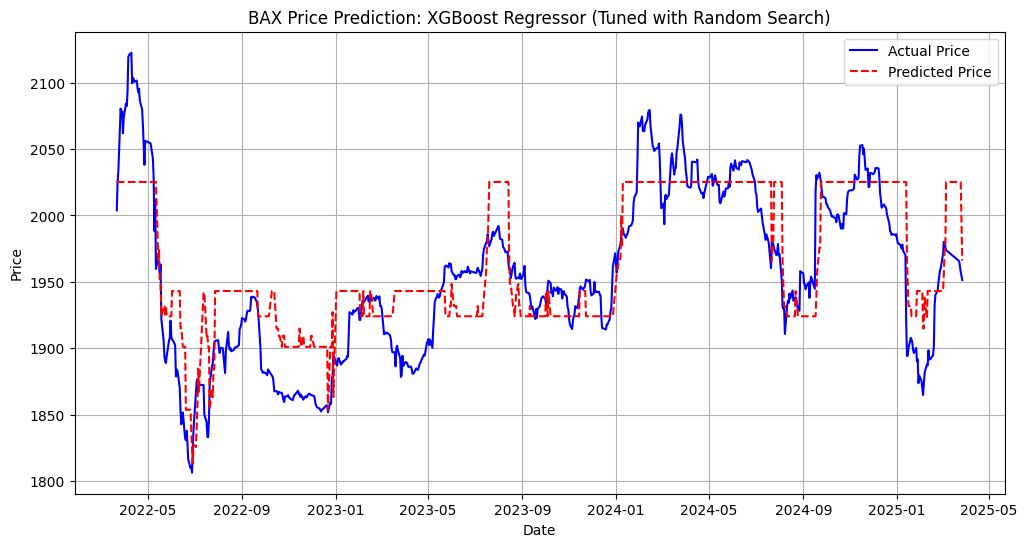

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import randint, uniform

# Load the dataset
try:
    df = pd.read_csv('/kaggle/input/xbm-random/df_bax_cleaned_to_view_outliers.csv')
except FileNotFoundError:
    print("Error: The file 'df_bax_cleaned_to_view_outliers.csv' was not found.")
    exit()

# --- 1. Data Preprocessing and Feature Engineering ---
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
data = df[['Price']].copy()

# Create lagged features
lags = [1, 2, 3, 5, 10]
for lag in lags:
    data[f'Price_lag_{lag}'] = data['Price'].shift(lag)

data.dropna(inplace=True)

X = data.drop('Price', axis=1)
y = data['Price']

# --- 2. Data Splitting ---
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

# --- 3. Hyperparameter Tuning with Randomized Search ---

# Define a wider range of parameters for the search
param_dist = {
    'n_estimators': randint(100, 1000), # Randomly samples an integer between 100 and 1000
    'max_depth': randint(3, 10),      # Randomly samples an integer between 3 and 10
    'learning_rate': uniform(0.01, 0.2), # Randomly samples a float between 0.01 and 0.2
    'subsample': uniform(0.6, 0.4),      # Randomly samples a float for subsample ratio
    'colsample_bytree': uniform(0.6, 0.4) # Randomly samples a float for feature subsampling
}

# Initialize the XGBoost Regressor
xg_model_base = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Initialize RandomizedSearchCV
# n_iter=50 means it will try 50 random combinations from the parameter distributions.
random_search = RandomizedSearchCV(
    estimator=xg_model_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\nStarting Randomized Search for hyperparameter tuning...")
random_search.fit(X_train, y_train)
print("Randomized Search complete.")

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert to positive RMSE
print(f"\nBest Parameters found: {best_params}")
print(f"Best RMSE from Randomized Search: {best_score:.2f}")

# --- 4. Model Training with Best Parameters ---

# Train a new model using the best parameters found by Randomized Search
final_xg_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42, n_jobs=-1)
print("\nTraining final XGBoost model with best parameters...")
final_xg_model.fit(X_train, y_train)
print("Training complete.")

# --- 5. Making Predictions ---
predictions = final_xg_model.predict(X_test)

# --- 6. Model Evaluation ---
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nFinal Mean Absolute Error (MAE): {mae:.2f}")
print(f"Final Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- 7. Visualization ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue')
plt.plot(y_test.index, predictions, label='Predicted Price', color='red', linestyle='--')
plt.title('BAX Price Prediction: XGBoost Regressor (Tuned with Random Search)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
